In [1]:
import torch
from transformers import ViTMAEForPreTraining
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from data_utils import WBCdataset, pRCCdataset
from torchvision import transforms
from torch.utils.data import DataLoader

# make random mask reproducible (comment out to make it change)
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(10)

model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
model2 = ViTMAEForPreTraining.from_pretrained("Mo0310/vitmae_pRCC_80epochs")

/environment/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
WBC_mean = np.array([0.7049, 0.5392, 0.5885])
WBC_std = np.array([0.1626, 0.1902, 0.0974])

pRCC_mean = np.array([0.6843, 0.5012, 0.6436])
pRCC_std = np.array([0.2148, 0.2623, 0.1969])

label_dict = {
    'Basophil': 0,
    'Eosinophil': 1,
    'Lymphocyte': 2,
    'Monocyte': 3,
    'Neutrophil': 4,
}

def get_pRCC_transform():
    data_transforms = []
    data_transforms.append(transforms.CenterCrop(768))
    data_transforms.append(transforms.RandomCrop((224, 224)))
    # data_transforms.append(transforms.RandomHorizontalFlip())
    data_transforms.append(transforms.ToTensor())
    data_transforms.append(transforms.Normalize(pRCC_mean, pRCC_std, inplace=True))
    return transforms.Compose(data_transforms)

def get_WBC_transform(is_train):
    data_transforms = []
    data_transforms.append(transforms.Resize((224, 224)))
    if is_train:
        data_transforms.append(transforms.RandomHorizontalFlip())
    data_transforms.append(transforms.ToTensor())
    data_transforms.append(transforms.Normalize(WBC_mean, WBC_std, inplace=True))
    return transforms.Compose(data_transforms)

pRCC = pRCCdataset(path_to_folder='../data/dataset/pRCC_nolabel', transform=get_pRCC_transform())
WBC = WBCdataset(path_to_folder='../data/dataset/WBC_10/train', label_dict=label_dict, transform=get_WBC_transform(True))
WBCloader = DataLoader(WBC, batch_size=64, shuffle=True)
pRCCloader = DataLoader(pRCC, batch_size=1, shuffle=True)
img, _ = next(iter(pRCCloader))

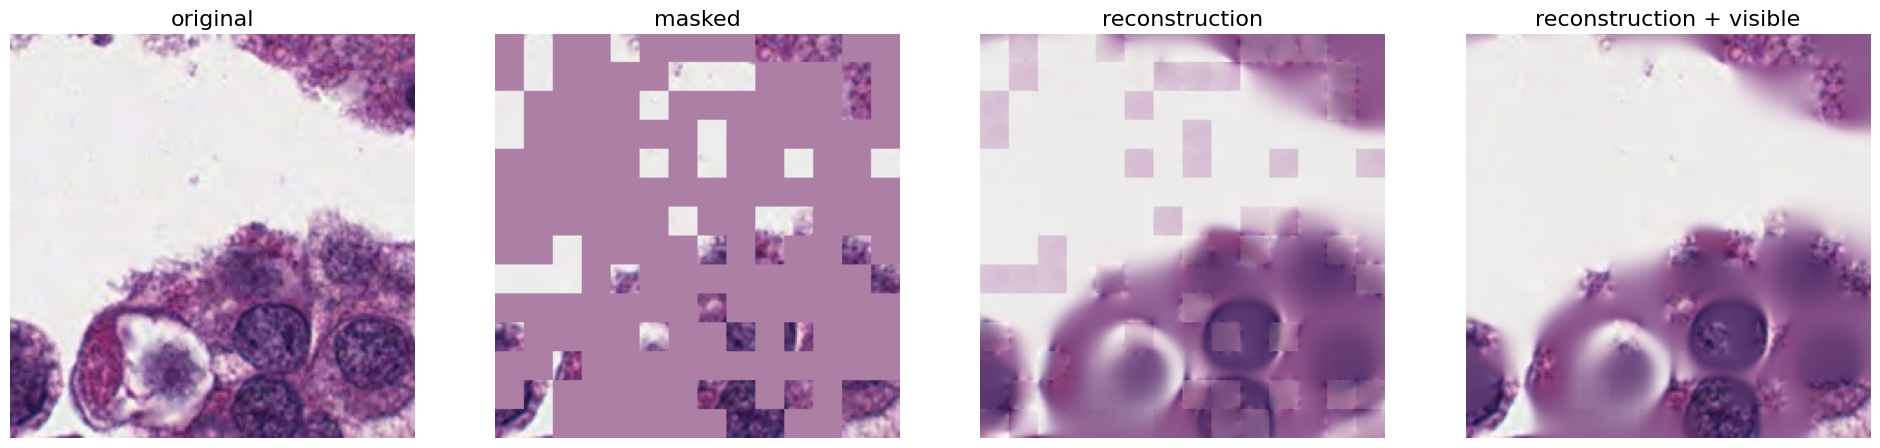

tensor(0.1590, grad_fn=<DivBackward0>)

In [3]:
def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * pRCC_std + pRCC_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    # forward pass
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()
    return outputs.loss


visualize(img, model2)